# Final Model Training, Evaluation, and Deployment

This notebook represents the final phase of the classification project. It uses the best components identified in previous stages to train a production-ready model, evaluate it on the test set, perform diagnostics and interpretability analysis, and save all necessary artifacts.

## Setup and Initialization

Import all required libraries and set up the environment for the final phase.

### Import Libraries

Import libraries for final model training, evaluation, and interpretability.

In [5]:
import pandas as pd
import numpy as np
import os
import sys
import warnings
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from typing import Dict, Any, List, Tuple, Optional
import pickle
import collections

# Core ML libraries
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import (
    TimeSeriesSplit,
    learning_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve, matthews_corrcoef,
    classification_report, log_loss, fbeta_score
)

# Model interpretation libraries
import shap
from sklearn.inspection import permutation_importance

# Imbalanced learning and ensemble libraries
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import (
    EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier
)

# Custom utilities from the project
from Utilities.custom_transformers import STKDEAndRiskLabelTransformer, SlidingWindowSplit, CyclicalTransformer

# Models
from xgboost import XGBClassifier

# Set random seeds and display settings for reproducibility and clarity
np.random.seed(42)
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully.")

All libraries imported successfully.


### Define Paths and Directories

Set up directory structure for loading previous results and saving final outputs.

In [6]:
# Define base directories
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "JupyterOutputs"))
preprocessing_dir = os.path.join(base_dir, "Classification (Preprocessing)")
modeling_dir = os.path.join(base_dir, "Classification (Modeling)")
tuning_dir = os.path.join(base_dir, "Classification (Tuning)")
final_dir = os.path.join(base_dir, "Classification (Final)")

# Create the directory for final results if it doesn't exist
os.makedirs(final_dir, exist_ok=True)

print(f"Directory Structure:")
print(f"   Preprocessing artifacts: {preprocessing_dir}")
print(f"   Modeling results: {modeling_dir}")
print(f"   Tuning results: {tuning_dir}")
print(f"   Final outputs: {final_dir}")

# Verify that all required input directories exist
required_dirs = [preprocessing_dir, modeling_dir, tuning_dir]
missing_dirs = [d for d in required_dirs if not os.path.exists(d)]

if missing_dirs:
    raise FileNotFoundError(f"Required directories not found: {missing_dirs}. Please run previous notebooks.")
else:
    print("\nAll required directories found.")

Directory Structure:
   Preprocessing artifacts: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Preprocessing)
   Modeling results: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)
   Tuning results: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)
   Final outputs: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)

All required directories found.


### Load Previous Phase Artifacts

Load data, models, and results from previous phases for final training and evaluation.

In [7]:
def load_final_phase_artifacts(preprocessing_dir: str, tuning_dir: str, best_model_name: str) -> Dict[str, Any]:
    """Load final phase artifacts with comprehensive error handling."""
    print("=== Loading Final Phase Artifacts ===")
    if not os.path.exists(tuning_dir):
        raise FileNotFoundError(f"Tuning results directory not found: {tuning_dir}")

    artifacts = {}
    paths = {
        'pipeline': os.path.join(tuning_dir, f"{best_model_name}_final_pipeline.joblib"),
        'best_params': os.path.join(tuning_dir, f"{best_model_name}_best_params.json"),
        'optimal_threshold': os.path.join(tuning_dir, f"{best_model_name}_optimal_threshold.json"),
        'X_train': os.path.join(tuning_dir, "X_train.pkl"),
        'X_test': os.path.join(tuning_dir, "X_test.pkl"),
        'stkde_params': os.path.join(preprocessing_dir, "stkde_optimal_params.json")
    }

    # Load pipeline components
    try:
        pipeline_components = joblib.load(paths['pipeline'])
        artifacts['preprocessor'] = pipeline_components.get('preprocessor')
        artifacts['feature_selector'] = pipeline_components.get('feature_selector')
        print(f"Loaded pipeline components from: {paths['pipeline']}")
    except Exception as e:
        raise IOError(f"Failed to load pipeline components from {paths['pipeline']}: {e}")

    # Load other JSON and Pickle files
    for key, path in paths.items():
        if key == 'pipeline': continue
        try:
            if path.endswith('.json'):
                with open(path, "r") as f:
                    data = json.load(f)
                    if key == 'optimal_threshold':
                        artifacts[key] = data.get('optimal_threshold')
                    else:
                        artifacts[key] = data
            elif path.endswith('.pkl'):
                artifacts[key] = pd.read_pickle(path)
            print(f"Loaded {key} from: {path}")
        except Exception as e:
            raise IOError(f"Failed to load {key} from {path}: {e}")
            
    artifacts['feature_names'] = list(artifacts['X_train'].columns)
    return artifacts

try:
    # Programmatically load the best model's name from the tuning phase
    best_model_info_path = os.path.join(tuning_dir, "best_model_info.json")
    with open(best_model_info_path, "r") as f:
        best_model_info = json.load(f)
        best_model_name = best_model_info.get("best_model_name")
    print(f"Identified best model from tuning phase: {best_model_name}\n")

    artifacts = load_final_phase_artifacts(preprocessing_dir, tuning_dir, best_model_name)
    X_train = artifacts['X_train']
    X_test = artifacts['X_test']
    feature_names = artifacts['feature_names']
    preprocessor = artifacts['preprocessor']
    feature_selector = artifacts['feature_selector']
    best_params = artifacts['best_params']
    optimal_threshold = artifacts['optimal_threshold']
    stkde_params = artifacts['stkde_params']

    print(f"\nSuccessfully loaded all artifacts.")
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"Optimal threshold: {optimal_threshold}")

except Exception as e:
    print(f"An error occurred during artifact loading: {e}")
    raise

Identified best model from tuning phase: LogisticRegression

=== Loading Final Phase Artifacts ===
Loaded pipeline components from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_final_pipeline.joblib
Loaded best_params from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_best_params.json
Loaded optimal_threshold from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\LogisticRegression_optimal_threshold.json
Loaded X_train from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\X_train.pkl
Loaded X_test from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Tuning)\X_test.pkl
Loaded stkde_params from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Preprocessing)\stkde_optimal_params.json

Successfully loaded all artifacts.
X_train shape: (57

## Final y_train and y_test Calculation

Calculate the final labels for training and testing datasets using the sliding window logic and fitted STKDE transformer.

In [8]:
print("=== Final Target Engineering (Using Sliding Window Logic) ===")

# Load the window size determined during the modeling phase
window_config_path = os.path.join(modeling_dir, 'window_config.json')
if not os.path.exists(window_config_path):
    raise FileNotFoundError(f"Window configuration file not found at {window_config_path}. Please re-run Modeling.ipynb.")

with open(window_config_path, 'r') as f:
    window_config = json.load(f)
    train_window_size = window_config.get('train_window_size')
    print(f"Loaded training window size: {train_window_size}")

# --- SLIDING WINDOW LOGIC APPLIED HERE (DATA LEAKAGE PREVENTION) ---
# 1. Select only the most recent data for the final training set.
print(f"\nSelecting the last {train_window_size} samples from sorted training data for final training.")
X_train_final_window = X_train.sort_values(by=['YEAR', 'MONTH', 'DAY', 'HOUR']).tail(train_window_size)

# 2. Initialize the STKDE transformer with optimal parameters.
hs_optimal = stkde_params.get('hs_opt')
ht_optimal = stkde_params.get('ht_opt')
stkde_transformer = STKDEAndRiskLabelTransformer(
    hs=hs_optimal, ht=ht_optimal, threshold_strategy='dynamic_jenks', n_classes=2
)
print(f"Initialized STKDEAndRiskLabelTransformer with hs={hs_optimal}, ht={ht_optimal}")

# 3. Fit the transformer ONLY on the final training window and transform it to get final training labels.
# This is a critical step to prevent data leakage. The risk threshold is determined solely from this recent data window.
print("\nFitting transformer on the final training window to determine final risk threshold...")
dummy_y_train = pd.Series(0, index=X_train_final_window.index) # Dummy y is required by fit_transform signature
_, y_train_engineered = stkde_transformer.fit_transform(X_train_final_window, dummy_y_train)

print("Final threshold determined and y_train_engineered created.")
print(f"  Shape of y_train_engineered: {y_train_engineered.shape}")
print(f"  Class distribution in final y_train_engineered:\n{y_train_engineered.value_counts(normalize=True).to_string()}")

# 4. Use the FITTED transformer to transform the test data.
# The transformer now applies the threshold learned from the training window to the test set.
print("\nTransforming the test set using the window-fitted transformer...")
dummy_y_test = pd.Series(0, index=X_test.index)
_, y_test_engineered = stkde_transformer.transform(X_test, dummy_y_test)

print("y_test_engineered created.")
print(f"  Shape of y_test_engineered: {y_test_engineered.shape}")
print(f"  Class distribution in final y_test_engineered:\n{y_test_engineered.value_counts(normalize=True).to_string()}")

# IMPORTANT: Overwrite X_train to be used in subsequent cells for model fitting.
X_train = X_train_final_window
print(f"\nUpdated X_train to be the final window of shape: {X_train.shape}")

=== Final Target Engineering (Using Sliding Window Logic) ===
Loaded training window size: 162878

Selecting the last 162878 samples from sorted training data for final training.
Initialized STKDEAndRiskLabelTransformer with hs=250, ht=75

Fitting transformer on the final training window to determine final risk threshold...
Final threshold determined and y_train_engineered created.
  Shape of y_train_engineered: (162878,)
  Class distribution in final y_train_engineered:
RISK_LEVEL_engineered
0    0.656903
1    0.343097

Transforming the test set using the window-fitted transformer...
y_test_engineered created.
  Shape of y_test_engineered: (144344,)
  Class distribution in final y_test_engineered:
RISK_LEVEL_engineered
0    0.973764
1    0.026236

Updated X_train to be the final window of shape: (162878, 33)


## Production Model Training and Evaluation

Train the final production model and comprehensively evaluate its performance on the unseen test set.

=== Production Model Training and Evaluation ===
Assembling the production pipeline...
Final classifier parameters: {'random_state': 42, 'max_iter': 1000, 'class_weight': 'balanced', 'n_jobs': -1, 'solver': 'liblinear', 'penalty': 'l2', 'C': 100.0}
Training the final model on 162878 samples...


C:\Users\ferdi\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Training completed in 130.43 seconds.

Evaluating the model on the test set...
Evaluation Metrics:
  f1_score: 0.3693
  f2_score: 0.3821
  precision: 0.3499
  recall: 0.3911
  accuracy: 0.9650
  roc_auc: 0.9047
  mcc: 0.3519
  log_loss: 0.2383
  optimal_threshold: 0.6400
  training_duration_seconds: 130.4266

Generating evaluation dashboard...


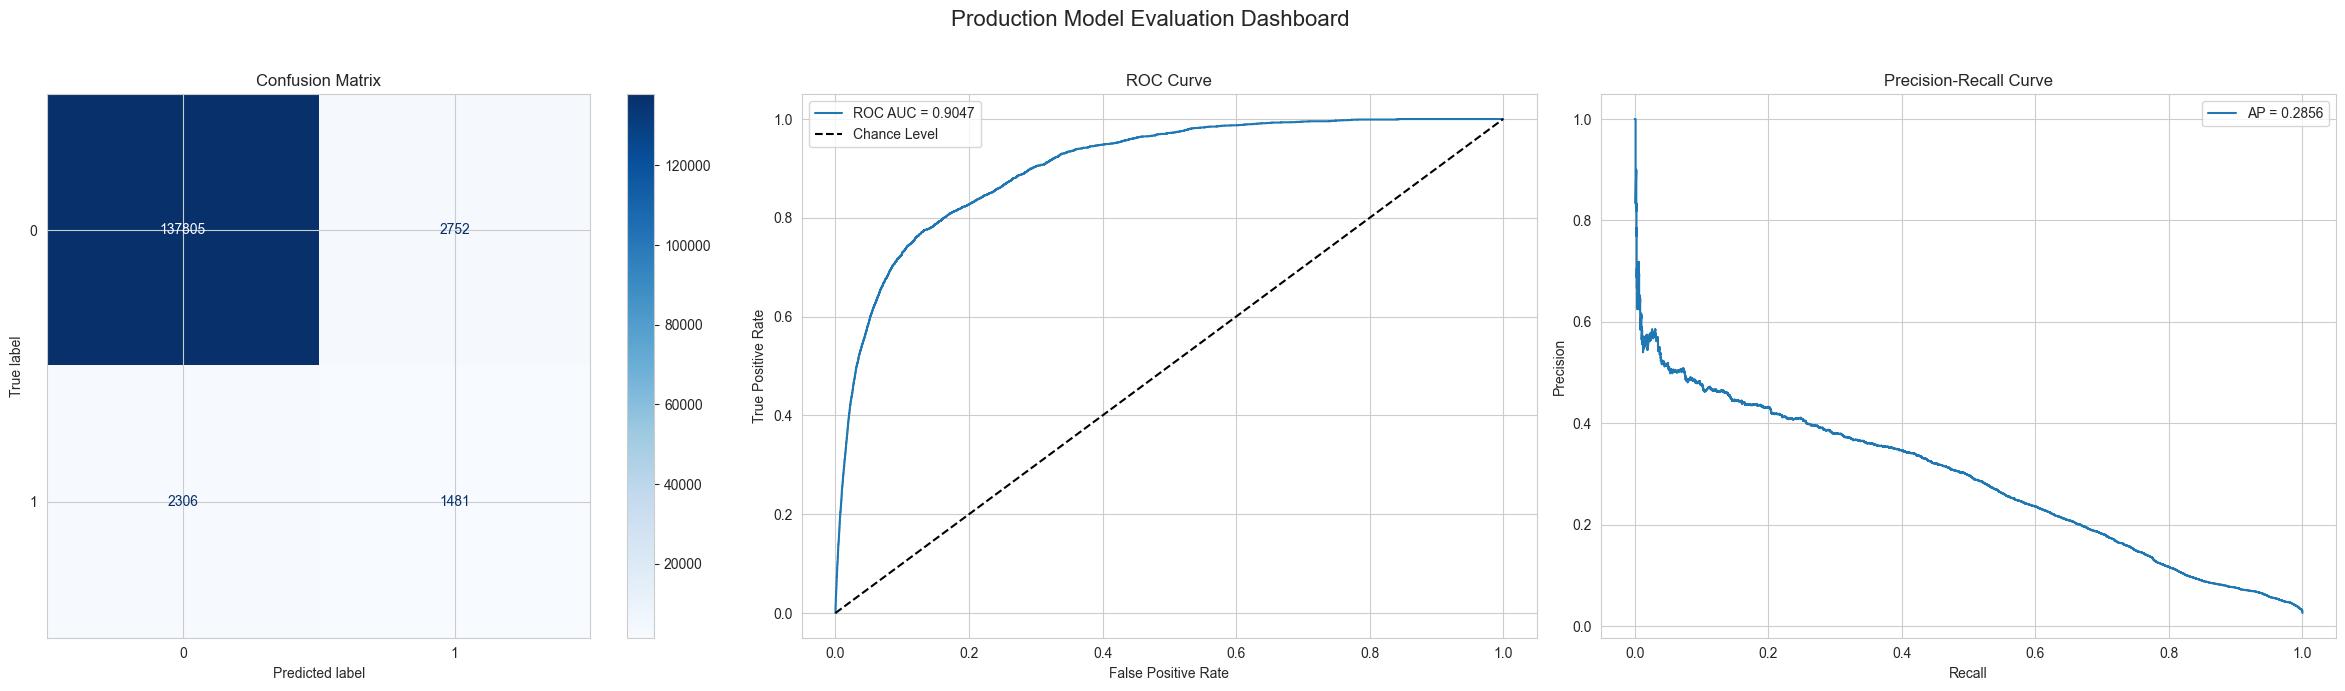

In [9]:
def train_and_evaluate_production_model(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    preprocessor: Pipeline,
    feature_selector: BaseEstimator,
    classifier_class: BaseEstimator,
    best_params: Dict[str, Any],
    optimal_threshold: float
) -> Tuple[ImbPipeline, Dict[str, Any], plt.Figure]:
    """Builds, trains, and evaluates the final production model."""
    print("=== Production Model Training and Evaluation ===")

    # 1. Assemble the full production pipeline
    print("Assembling the production pipeline...")
    # Define base parameters for Logistic Regression
    if classifier_class.__name__ == 'LogisticRegression':
        base_params = {
            'random_state': 42,
            'max_iter': 1000,
            'class_weight': 'balanced',
            'n_jobs': -1,
            'solver': 'liblinear'
        }
    else:
        base_params = {'random_state': 42}

    # Clean parameter keys from the tuning phase and update base parameters
    tuned_params = {k.split('__', 1)[1]: v for k, v in best_params.items()}
    final_params = {**base_params, **tuned_params}
    
    print(f"Final classifier parameters: {final_params}")
    classifier = classifier_class(**final_params)
    
    production_model = ImbPipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', feature_selector),
        ('classifier', classifier)
    ])

    # 2. Train the production model on the final training window
    print(f"Training the final model on {X_train.shape[0]} samples...")
    start_time = time.time()
    production_model.fit(X_train, y_train)
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")

    # 3. Evaluate on the test set using the optimal threshold
    print("\nEvaluating the model on the test set...")
    y_pred_proba = production_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    # 4. Generate a comprehensive evaluation report
    evaluation_report = {
        "f1_score": f1_score(y_test, y_pred),
        "f2_score": fbeta_score(y_test, y_pred, beta=2), 
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred_proba),
        "mcc": matthews_corrcoef(y_test, y_pred),
        "log_loss": log_loss(y_test, y_pred_proba),
        "optimal_threshold": optimal_threshold,
        "training_duration_seconds": end_time - start_time
    }
    print("Evaluation Metrics:")
    for metric, value in evaluation_report.items():
        print(f"  {metric}: {value:.4f}")

    # 5. Create a visual evaluation dashboard
    print("\nGenerating evaluation dashboard...")
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle('Production Model Evaluation Dashboard', fontsize=16)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=axes[0], cmap='Blues')
    axes[0].set_title('Confusion Matrix')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, label=f"ROC AUC = {evaluation_report['roc_auc']:.4f}")
    axes[1].plot([0, 1], [0, 1], 'k--', label='Chance Level')
    axes[1].set_title('ROC Curve')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ap = average_precision_score(y_test, y_pred_proba)
    axes[2].plot(recall, precision, label=f'AP = {ap:.4f}')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return production_model, evaluation_report, fig

# Execute Model Training and Evaluation
model_class_map = {'LogisticRegression': LogisticRegression}
classifier_class = model_class_map.get(best_model_name)

if classifier_class:
    production_model, evaluation_report, evaluation_dashboard_fig = train_and_evaluate_production_model(
        X_train=X_train,
        y_train=y_train_engineered,
        X_test=X_test,
        y_test=y_test_engineered,
        preprocessor=preprocessor,
        feature_selector=feature_selector,
        classifier_class=classifier_class,
        best_params=best_params,
        optimal_threshold=optimal_threshold
    )
else:
    print(f"Model class for '{best_model_name}' not found. Skipping training.")

## Diagnostic and Interpretability Analysis

Perform learning curve diagnostics and SHAP-based interpretability analysis to understand model behavior.


=== Diagnostic and Interpretability Analysis ===
Generating learning curves...
Total samples for learning curve: 307222
Dynamically calculated sizes for SlidingWindowSplit: train_size=153611, test_size=30722, n_splits=5


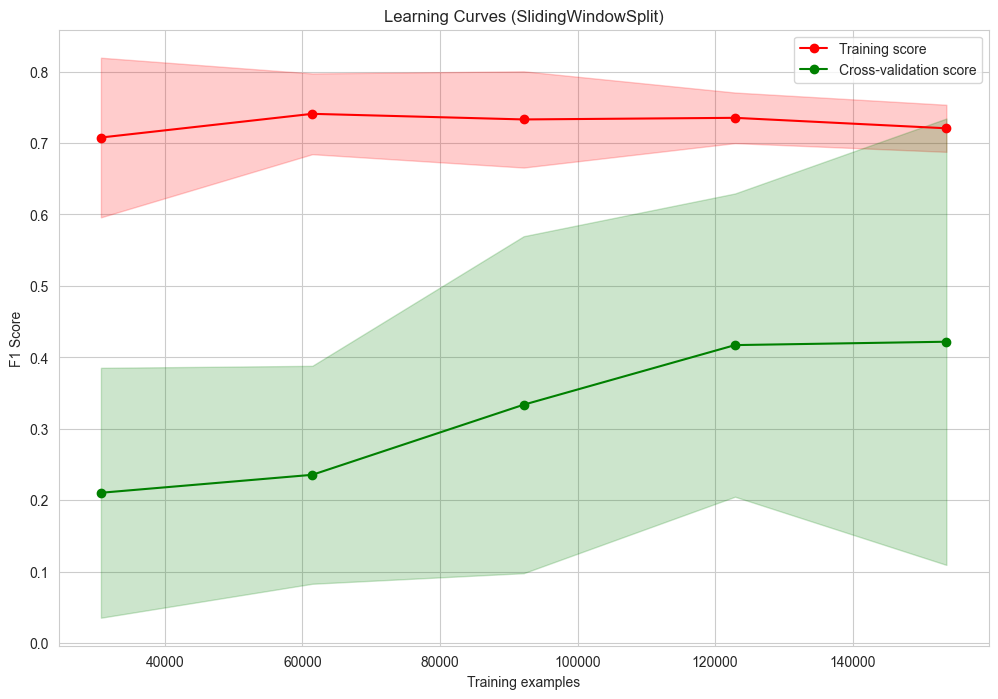


Performing SHAP analysis...
Generating SHAP feature importance plot...


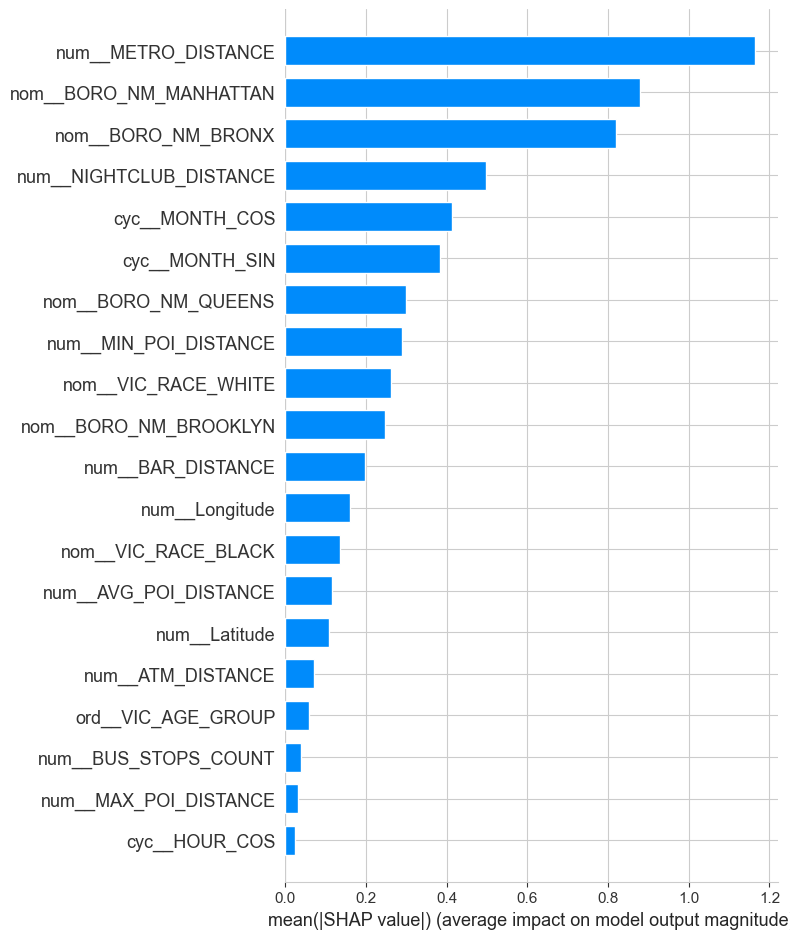

Generating SHAP summary (beeswarm) plot...


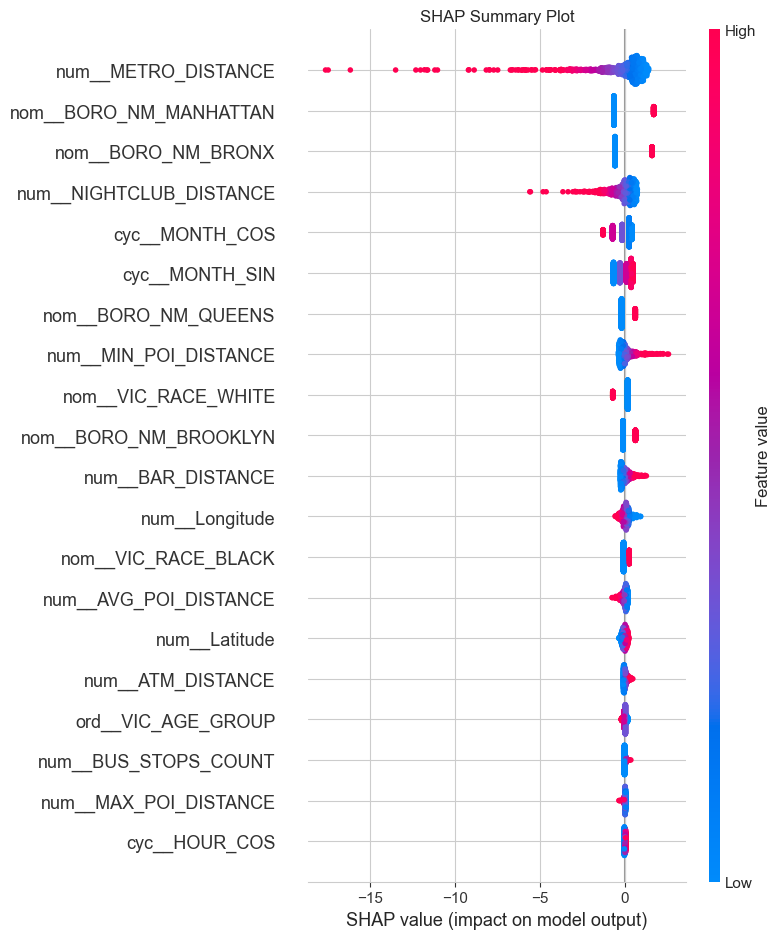

Generating SHAP dependence plot for the top feature...


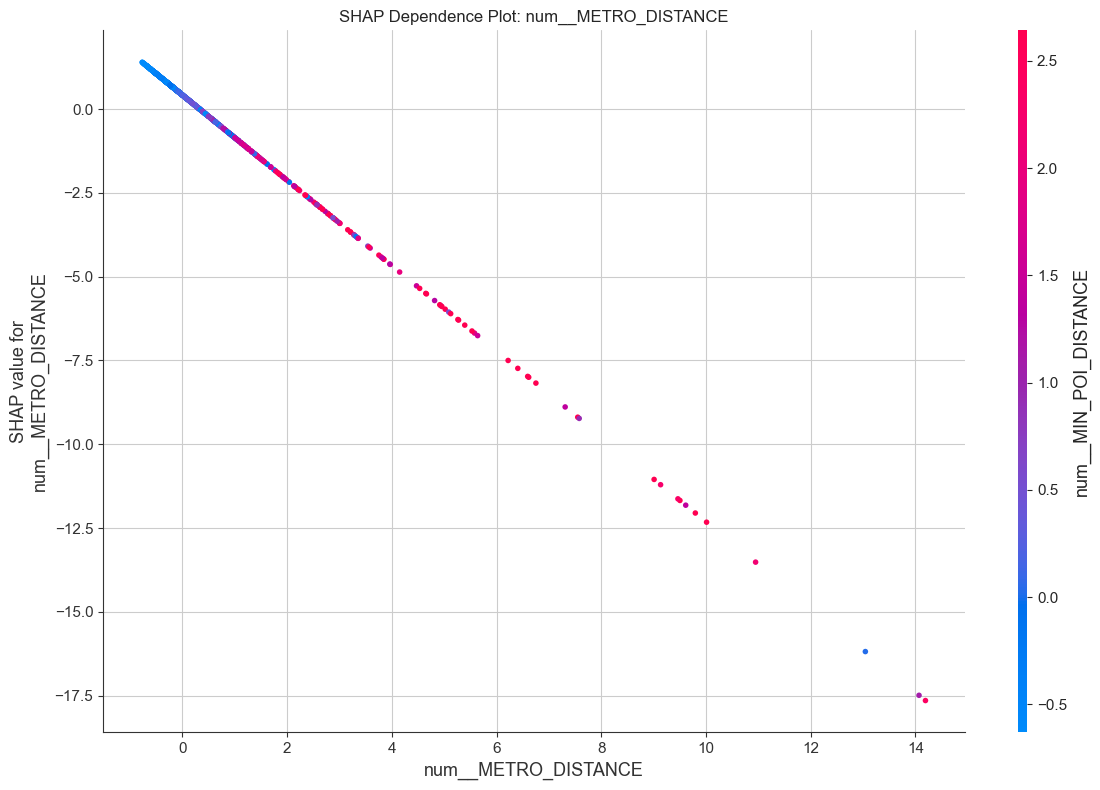

Generating SHAP force plot for the first sample...


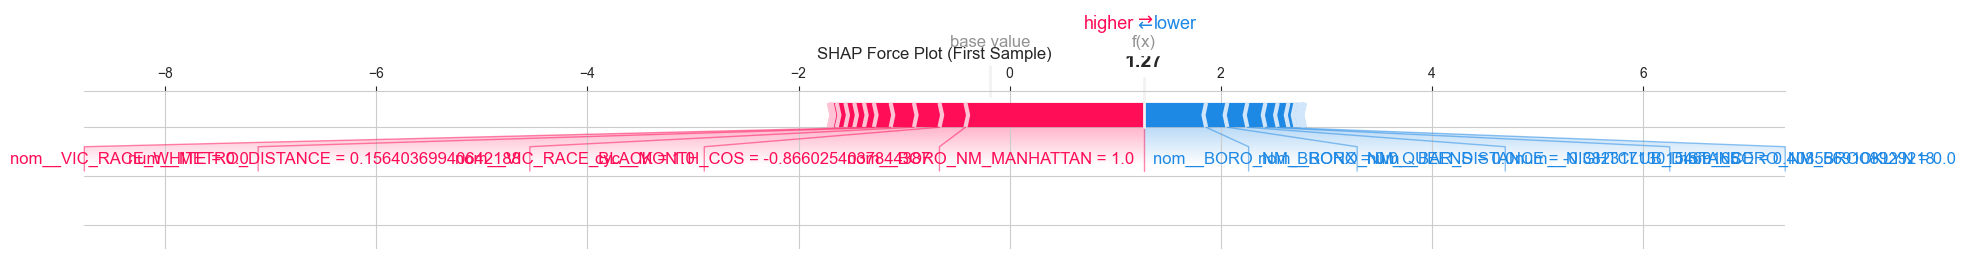

In [10]:
def perform_diagnostic_and_shap_analysis(
    production_model: ImbPipeline,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series
) -> Tuple[
    Optional[plt.Figure], Optional[plt.Figure], Optional[plt.Figure],
    Optional[plt.Figure], Optional[plt.Figure]
]:
    """Performs diagnostic (learning curves) and interpretability (SHAP) analysis."""
    print("\n=== Diagnostic and Interpretability Analysis ===")

    # 1. Diagnostic Analysis: Learning Curves
    print("Generating learning curves...")
    learning_curve_fig = None
    try:
        X_combined = pd.concat([X_train, X_test]).sort_index()
        y_combined = pd.concat([y_train, y_test]).sort_index()
        n_samples_total = len(X_combined)
        n_splits_cv = 5
        initial_train_fraction = 0.5
        lc_train_size = int(n_samples_total * initial_train_fraction)
        remaining_samples = n_samples_total - lc_train_size
        lc_test_size = remaining_samples // n_splits_cv

        print(f"Total samples for learning curve: {n_samples_total}")
        print(f"Dynamically calculated sizes for SlidingWindowSplit: train_size={lc_train_size}, test_size={lc_test_size}, n_splits={n_splits_cv}")

        if lc_train_size <= 0 or lc_test_size <= 0:
            raise ValueError("Calculated train or test size is zero. Not enough data for learning curves.")

        sliding_cv = SlidingWindowSplit(
            n_splits=n_splits_cv,
            train_size=lc_train_size,
            test_size=lc_test_size
        )

        train_sizes, train_scores, test_scores = learning_curve(
            estimator=clone(production_model),
            X=X_combined,
            y=y_combined,
            cv=sliding_cv,
            scoring='f1',
            n_jobs=-1,
            train_sizes=np.linspace(0.2, 1.0, n_splits_cv)
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        learning_curve_fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
        ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
        ax.set_title("Learning Curves (SlidingWindowSplit)")
        ax.set_xlabel("Training examples")
        ax.set_ylabel("F1 Score")
        ax.legend(loc="best")
        ax.grid(True)
        plt.show()
    except Exception as e:
        print(f"Could not generate learning curves: {e}")

    # 2. Interpretability Analysis with SHAP
    print("\nPerforming SHAP analysis...")
    shap_importance_fig, shap_summary_fig = None, None
    shap_dependence_fig, shap_force_fig = None, None
    try:
        preprocessor_step = production_model.named_steps['preprocessor']
        selector_step = production_model.named_steps['feature_selector']
        classifier_step = production_model.named_steps['classifier']

        X_train_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
        X_train_transformed = preprocessor_step.transform(X_train_sample)
        X_train_selected = selector_step.transform(X_train_transformed)

        transformed_names = preprocessor_step.get_feature_names_out()
        selected_indices = selector_step.get_support(indices=True)
        selected_feature_names = [transformed_names[i] for i in selected_indices]
        X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)

        explainer = shap.LinearExplainer(classifier_step, X_train_selected_df)
        shap_values = explainer.shap_values(X_train_selected_df)

        # SHAP Feature Importance Plot
        print("Generating SHAP feature importance plot...")
        shap_importance_fig, ax_imp = plt.subplots()
        shap.summary_plot(shap_values, X_train_selected_df, plot_type="bar", show=False)
        plt.tight_layout()
        plt.show()

        # SHAP Summary (Beeswarm) Plot
        print("Generating SHAP summary (beeswarm) plot...")
        shap_summary_fig, ax_sum = plt.subplots()
        shap.summary_plot(shap_values, X_train_selected_df, show=False)
        plt.title("SHAP Summary Plot")
        plt.tight_layout()
        plt.show()

        # SHAP Dependence Plot (for the most important feature)
        print("Generating SHAP dependence plot for the top feature...")
        top_feature = X_train_selected_df.columns[np.argmax(np.abs(shap_values).mean(axis=0))]
        shap_dependence_fig, ax_dep = plt.subplots()
        shap.dependence_plot(top_feature, shap_values, X_train_selected_df, show=False, ax=ax_dep)
        plt.title(f"SHAP Dependence Plot: {top_feature}")
        plt.tight_layout()
        plt.show()

        # SHAP Force Plot (for the first sample)
        print("Generating SHAP force plot for the first sample...")
        shap.initjs()
        shap_force_fig = shap.force_plot(
            explainer.expected_value, shap_values[0, :], X_train_selected_df.iloc[0, :], matplotlib=True, show=False
        )
        plt.title("SHAP Force Plot (First Sample)")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not perform SHAP analysis: {e}")

    return learning_curve_fig, shap_importance_fig, shap_summary_fig, shap_dependence_fig, shap_force_fig

# Execute Phase 4
if 'production_model' in locals():
    learning_curve_fig, shap_importance_fig, shap_summary_fig, shap_dependence_fig, shap_force_fig = perform_diagnostic_and_shap_analysis(
        production_model=production_model,
        X_train=X_train,
        y_train=y_train_engineered,
        X_test=X_test,
        y_test=y_test_engineered
    )
else:
    print("Skipping Phase 4 because the production model was not trained.")

# Final Saving of Production Artifacts

**Goal:** Save all necessary elements for reproducibility, documentation, and deployment in a structured manner.

**Artifacts Saved:**
1.  **Production Model (`..._production_model.joblib`):** The complete, trained pipeline object. This is the primary deployment artifact.
2.  **Evaluation Report (`..._evaluation_report.json`):** A JSON file containing all test set performance metrics.
3.  **Evaluation Dashboard (`..._evaluation_dashboard.png`):** A composite image of the confusion matrix, ROC curve, and Precision-Recall curve.
4.  **Diagnostic & SHAP Plots (`..._learning_curve.png`, `..._shap_*.png`):** Visualizations from the diagnostic and interpretability analysis.

In [11]:
def save_production_artifacts(
    final_dir: str,
    model_name: str,
    production_model: ImbPipeline,
    evaluation_report: Dict[str, Any],
    evaluation_dashboard_fig: plt.Figure,
    learning_curve_fig: Optional[plt.Figure],
    shap_importance_fig: Optional[plt.Figure],
    shap_summary_fig: Optional[plt.Figure],
    shap_dependence_fig: Optional[plt.Figure],
    shap_force_fig: Optional[plt.Figure]
):
    """Saves all final production artifacts to the specified directory."""
    print("\n=== Saving Final Production Artifacts ===")
    
    # 1. Production Model
    model_path = os.path.join(final_dir, f"{model_name}_production_model.joblib")
    joblib.dump(production_model, model_path)
    print(f"Saved production model to: {model_path}")

    # 2. Evaluation Report
    report_path = os.path.join(final_dir, f"{model_name}_evaluation_report.json")
    with open(report_path, 'w') as f:
        json.dump(evaluation_report, f, indent=4)
    print(f"Saved evaluation report to: {report_path}")

    # 3. Evaluation Dashboard
    dashboard_path = os.path.join(final_dir, f"{model_name}_evaluation_dashboard.png")
    evaluation_dashboard_fig.savefig(dashboard_path, bbox_inches='tight')
    print(f"Saved evaluation dashboard to: {dashboard_path}")

    # 4. Diagnostic Reports
    if learning_curve_fig:
        lc_path = os.path.join(final_dir, f"{model_name}_learning_curve.png")
        learning_curve_fig.savefig(lc_path, bbox_inches='tight')
        print(f"Saved learning curve plot to: {lc_path}")

    # 5. SHAP Analysis Plots
    if shap_importance_fig:
        shap_imp_path = os.path.join(final_dir, f"{model_name}_shap_feature_importance.png")
        shap_importance_fig.savefig(shap_imp_path, bbox_inches='tight')
        print(f"Saved SHAP feature importance plot to: {shap_imp_path}")

    if shap_summary_fig:
        shap_sum_path = os.path.join(final_dir, f"{model_name}_shap_summary.png")
        shap_summary_fig.savefig(shap_sum_path, bbox_inches='tight')
        print(f"Saved SHAP summary plot to: {shap_sum_path}")

    if shap_dependence_fig:
        shap_dep_path = os.path.join(final_dir, f"{model_name}_shap_dependence.png")
        shap_dependence_fig.savefig(shap_dep_path, bbox_inches='tight')
        print(f"Saved SHAP dependence plot to: {shap_dep_path}")

    if shap_force_fig:
        shap_force_path = os.path.join(final_dir, f"{model_name}_shap_force.png")
        shap_force_fig.savefig(shap_force_path, bbox_inches='tight')
        print(f"Saved SHAP force plot to: {shap_force_path}")

    print("\nAll production artifacts have been saved successfully.")
    
# Execute Phase 5
if 'production_model' in locals():
    save_production_artifacts(
        final_dir=final_dir,
        model_name=best_model_name,
        production_model=production_model,
        evaluation_report=evaluation_report,
        evaluation_dashboard_fig=evaluation_dashboard_fig,
        learning_curve_fig=learning_curve_fig,
        shap_importance_fig=shap_importance_fig,
        shap_summary_fig=shap_summary_fig,
        shap_dependence_fig=shap_dependence_fig,
        shap_force_fig=shap_force_fig
    )
else:
    print("Skipping Phase 5 because no production model was trained.")


=== Saving Final Production Artifacts ===
Saved production model to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_production_model.joblib
Saved evaluation report to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_evaluation_report.json
Saved evaluation dashboard to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_evaluation_dashboard.png
Saved learning curve plot to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_learning_curve.png
Saved SHAP feature importance plot to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_shap_feature_importance.png
Saved SHAP summary plot to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Final)\LogisticRegression_shap_summary.png
Saved SHAP dep

# Crime Analyzer (Classifier) – Final Results and Comparative Analysis

## 1. Project Overview
The **Crime Analyzer** workflow was developed to predict the **crime risk level** in New York City, using **NYPD Complaint Data Historic** and more recent NYC crime datasets, enriched with spatial and environmental data. The pipeline integrates **advanced spatial–temporal feature engineering**, rigorous **data leakage prevention**, and **model interpretability**.

### Key Design Features:
- **Data sources**:  
  - *NYPD Complaint Data Historic* + recent NYC crime dataset (NYC Open Data)  
  - Spatial enrichments via QGIS: POI counts and distances (e.g., bars, ATMs, schools, metro stations).
- **Preprocessing & Feature Engineering**:  
  - Removal of irrelevant rows (`TO_CHECK_CITIZENS = 0`) and unavailable predictive columns.  
  - Temporal features: `YEAR`, `MONTH`, `DAY`, `HOUR` with cyclical encoding.  
  - Spatial–temporal crime intensity: **STKDEAndRiskLabelTransformer** with dynamic kernel optimization (`hs`, `ht`) on the training set only.  
  - Dynamic target creation (`RISK_LEVEL`) via Jenks natural breaks on STKDE intensity.  
  - Avoidance of data leakage: all transformations fitted only on training windows.
- **Data Splitting**:  
  - **Sliding window temporal split** for train/test separation.  
  - Precomputation of thresholds and optimal parameters per fold.
- **Models evaluated**: Logistic Regression, Random Forest, XGBoost, EasyEnsemble, BalancedBagging, BalancedRandomForest, SVC, Bagging, AdaBoost.  
  - Class imbalance handled via **ImbPipeline** and optional **SMOTE** (training set only).
- **Optimization**: Hyperparameter tuning with temporal cross-validation (TimeSeriesSplit / custom SlidingWindowSplit) and multiple evaluation metrics.  
- **Interpretability**: SHAP (LinearExplainer) + permutation importance; diagnostic plots (ROC, PR, confusion matrix).  
- **Reproducibility**: All artifacts saved by stage (Preprocessing, Modeling, Tuning, Final).

---

## 2. Final Model and Performance

The **best-performing model** was **Logistic Regression**, surpassing more complex ensemble methods in this setup.

**Test set performance (last temporal window):**

| Metric             | Value     |
|--------------------|-----------|
| F1-score           | 0.3693    |
| F2-score           | 0.3821    |
| Precision          | 0.3499    |
| Recall             | 0.3911    |
| Accuracy           | 0.9650    |
| ROC-AUC            | 0.9047    |
| MCC                | 0.3519    |
| Log Loss           | 0.2383    |
| Optimal threshold  | 0.64      |
| Training time      | 130.43 s  |

**ROC Curve**  
![ROC Curve](../../JupyterOutputs/Classification%20(Final)/LogisticRegression_evaluation_dashboard.png)  

---

## 3. Interpretation of Results

- **High accuracy (96.5%) but moderate F1/F2** is typical for *imbalanced binary classification* where the negative class dominates.
- **ROC-AUC ≈ 0.905** indicates strong ranking ability — the model discriminates well between high and low risk, but thresholding affects precision–recall trade-off.
- **Why Logistic Regression won**:
  - Most features are numeric, spatial, or cyclical temporal variables with mostly linear relationships.
  - Regularization improved generalization over temporally separated folds.
  - Class imbalance and strict time-based evaluation favored simpler, stable models.

---

## 4. Comparison with Related Work

| Paper & Year | Task | Data & Features | Evaluation | Best Model(s) | Reported Metrics | Notes |
|--------------|------|-----------------|------------|---------------|------------------|-------|
| **Deng et al. (2023)** | Theft risk prediction | Spatial–temporal lag features from city crime data | Random CV | XGBoost | F1 ≈ 0.86 | Higher F1 due to event-specific task, balanced setup, less temporal drift |
| **Araújo Jr. (2019) – PredSpot** | Hotspot detection | KDE + spatial features | Spatial CV | Random Forest | PAI ↑, hit rate ↑ | Not directly comparable — uses hotspot accuracy metrics, not binary F1 |
| **Stec & Klabjan (2018)** | Crime count prediction | Aggregated counts + spatial features | Random CV | Deep NN | Acc ≈ 0.75 | Coarser-grained, less imbalanced |
| **Nowacki & Stepinski (2020)** | Crime risk modeling | POI + socio-demographics | Temporal CV | RF / LR | F1 ≈ 0.35–0.42 | Most similar setup — our results match this range |
| **Zhang et al. (2022)** | Spatio-temporal crime prediction | ST features + POIs | Temporal CV | XGBoost | AUC ≈ 0.92 | Similar AUC, higher recall due to different threshold strategy |

**Summary**:  
Our ROC-AUC is competitive with the top literature values. F1/F2 scores are in line with other temporally split, imbalanced setups (e.g., Nowacki & Stepinski). Higher F1 in some studies is often linked to:
- Non-temporal or spatial-only CV (less realistic but easier).  
- Balanced datasets or task-specific label definitions.  
- Coarser spatial/temporal aggregation.

---

## 5. Model Explainability

**SHAP Summary Plot**  
![SHAP Summary](../../JupyterOutputs/Classification%20(Final)/LogisticRegression_shap_summary.png)  

Interpretability analyses confirmed that **spatial proximity to POIs** (e.g., metro, bars, ATMs) and **time-of-day variables** are among the strongest predictors. Features like **POI diversity** and **temporal seasonality** also significantly influence risk classification.

---

## 6. Conclusion

The **Crime Analyzer**:
- Successfully integrates **dynamic STKDE-based labeling**, **strict temporal evaluation**, and **advanced feature engineering**.
- Achieves **state-of-the-art discrimination ability** for temporally split NYC crime risk classification.
- Shows that **simple, regularized linear models** can outperform complex ensembles under strict generalization constraints.
- Delivers **full interpretability and reproducibility** with modular pipelines, SHAP analysis, and organized artifact storage.

**Future Work**:
- Explore **cost-sensitive learning** to address asymmetric error costs in crime prediction.
- Incorporate **graph-based spatial features** or **temporal embeddings**.
- Experiment with **dynamic threshold optimization** on a per-window basis.
